In [6]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import create_fake_data as cr
reload(cr)
sys.path.append('../code_general_Finkelsteinlab')
import plotting_Finkelsteinlab as pltData
reload(pltData);

model_ID = 'Clv_init_limit_Saturated_general_energies_v2'
times = [0.0,12.0,60.0,180.0,600.0,1800.0,6000.0,18000.0,60000.0]
guide = 20

path_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
filename_data = 'ECas9_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'

### Show result of fit

In [7]:
filename = 'fit_4_3_2019_sim_3.txt'
path = '4_3_2019/run1/'
data = pd.read_table(path+filename,index_col=False)
final_par = data.loc[len(data)-1,'Parameter 1':'Parameter 43']
final_par_np = final_par.values
chi = data.loc[:,'Potential']
data.tail()

,Parameter 1,Parameter 2,Parameter 3,Parameter 4,Parameter 5,Parameter 6,Parameter 7,Parameter 8,Parameter 9,Parameter 10,...,Parameter 36,Parameter 37,Parameter 38,Parameter 39,Parameter 40,Parameter 41,Parameter 42,Parameter 43,Potential,Equilibruim
903,-4.345879,1.346636,-2.564376,-1.829806,0.138388,5.314123,-4.322263,1.435131,-0.375352,5.138404,...,2.441971,2.236726,1.631775,4.216779,6.644557,0.969141,2.427983,0.492013,221.916594,True
904,-4.338011,1.346997,-2.567325,-1.831623,0.142050,5.317199,-4.337998,1.437641,-0.377418,5.123573,...,2.446198,2.218765,1.626346,4.218065,6.650267,0.952044,2.427298,0.483634,222.231527,True
905,-4.322683,1.342842,-2.574571,-1.825624,0.147597,5.312549,-4.332287,1.433676,-0.390335,5.127510,...,2.454685,2.228293,1.636791,4.207582,6.670105,0.949422,2.422763,0.498244,221.938672,True
906,-4.331151,1.341423,-2.570854,-1.836730,0.145679,5.327315,-4.339571,1.429182,-0.382811,5.131325,...,2.439308,2.239182,1.651367,4.217128,6.662394,0.937041,2.427323,0.488645,220.640379,True
907,-4.348848,1.352396,-2.570280,-1.830462,0.151022,5.314069,-4.324701,1.426031,-0.381215,5.127508,...,2.441251,2.267237,1.641387,4.238665,6.667237,0.943062,2.427929,0.491003,220.680849,True


Text(0.5,1,'difference in parameters squared')

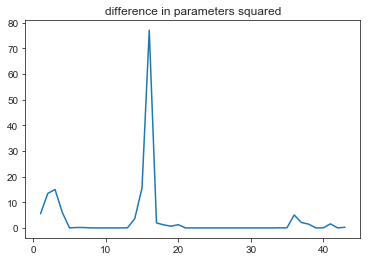

In [8]:
parameters = np.loadtxt('example-params-2.txt')
difference_sqrd = (parameters-final_par_np)**2
plt.figure
plt.plot(range(1,44),difference_sqrd)
plt.title('difference in parameters squared')

## Single mismatches

(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
 <a list of 7 Text yticklabel objects>)

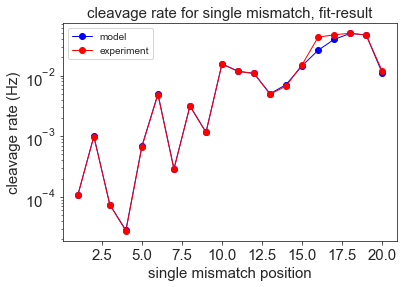

In [9]:
data_exp = pd.read_csv(path_data + filename_data)
k_exp_pd = pltData.plot_single_mut_data(data_exp, 'cleavage_rate', 'r', Canonical=True, data_name='cleavage rate (Hz)', Plot=False, 
                                                    logplot=False, SaveFigures=False)
k_exp = k_exp_pd.values[:,1]

_, k_fake, _ = cr.create_fake_data()
k_fake = k_fake[1:21]

k = np.zeros(20)
for i in range(1,guide+1):
    mismatch = [i]
    k[i-1] = clv.calc_clv_rate_fast(final_par_np,model_ID,mismatch,guide)
    
plt.figure
plt.semilogy(range(1,21),k, marker='o', linewidth=1, color='blue')
plt.semilogy(range(1,21),k_fake, marker='o', linewidth=1, color='red')
plt.xlabel('single mismatch position', fontsize=15)
plt.ylabel('cleavage rate (Hz)', fontsize=15)
plt.title('cleavage rate for single mismatch, fit-result', fontsize=15)
plt.legend(['model','experiment'])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

## Double mismatches

Text(0.5,1,'double mismatches, top=model bottom=experiment')

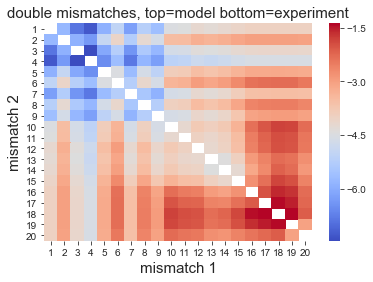

In [10]:
data_exp = pd.read_csv(path_data + filename_data)
_, k_matrix_experiment = pltData.plot_double_mut_data(data_exp, 'cleavage_rate', 'r', Canonical=True, Ng=20, data_name='cleavage rate (Hz)', Plot=False, logplot=True,
                        SaveFigures=False, figure_name='./Figure.pdf')
k_matrix_experiment.fillna(0, inplace=True)

k_matrix = np.zeros([20,20])
k_matrix_fake = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix[i-1,j-1] = np.log10(clv.calc_clv_rate_fast(final_par_np,model_ID,mismatch_positions,guide))
        
for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        k_matrix_fake[j-1,i-1] = np.log10(clv.calc_clv_rate_fast(parameters,model_ID,mismatch_positions,guide))
        
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))
k_df_fake = pd.DataFrame(k_matrix_fake, index=range(1, 21), columns=range(1, 21))
combined_df = k_df + k_matrix_experiment
combined_df_fake = k_df + k_df_fake

for i in range(1,21):
    combined_df[i].loc[i]=np.nan
    combined_df_fake[i].loc[i]=np.nan

sns.heatmap(combined_df_fake, cmap='coolwarm', cbar=True)
plt.xlabel('mismatch 1', fontsize=15)
plt.ylabel('mismatch 2', fontsize=15)
plt.title('double mismatches, top=model bottom=experiment', fontsize=15)


## Chi squared evolution

(array([-10000.,      0.,  10000.,  20000.,  30000.,  40000.,  50000.,
         60000.,  70000.]), <a list of 9 Text yticklabel objects>)

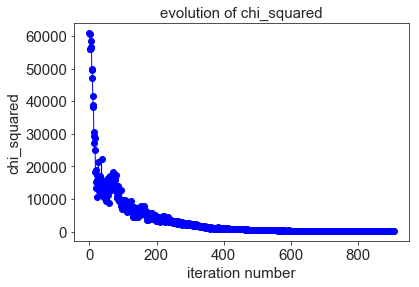

In [11]:
plt.plot(chi, marker='o', linewidth=1, color='blue')
plt.xlabel('iteration number', fontsize=15)
plt.ylabel('chi_squared', fontsize=15)
plt.title('evolution of chi_squared', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)